In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt
from os.path import join
from scipy.spatial.distance import cdist    
from scipy.sparse import csgraph

# Run1

In [ ]:
data_path = '/Users/zkavian/Desktop/Workspace/Python_code/GLMSingle/selected_voxels_session1_run1.nii.gz'
stat_img = nib.load(data_path)
selected_voxels = stat_img.get_fdata() #binary matrix (90,120,85)

results = np.load('/Users/zkavian/Downloads/GLMOutputs2-sub04-ses01/TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()
beta_values = betasmd = results['betasmd'][:,:,:,0:90]  #(90,120,85,90)

v1 = beta_values[selected_voxels.astype(bool), :] #(8252, 90)
mean_v1 = np.mean(v1, axis=-1)
C1 = 1./np.abs(mean_v1)

# print(f"Max: {C1.max()}")
# print(f"mean: {C1.mean()}")
# print(f"Min: {C1.min()}")

Max: 151.166259765625
mean: 4.421987533569336
Min: 0.03127579763531685


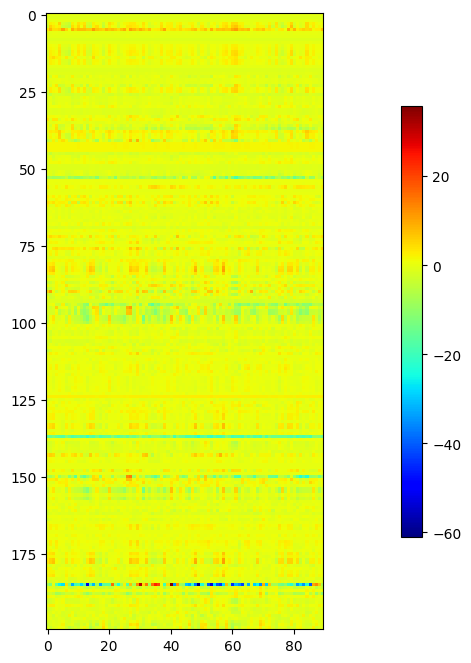

In [ ]:
# plt.figure(figsize=(20,8))
# img = plt.imshow(v1[:200], cmap='jet')
# plt.colorbar(img, shrink=0.7)
# plt.show()

In [8]:
base_path = '/Volumes/McKeownLab/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
sub = '04'
ses = '2'
run = '1'

data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg_2mm.nii.gz'
data_path_org = join(base_path, f'sub-pd0{sub}',f'ses-{ses}','func', data_name)
data_run1 = nib.load(data_path_org).get_fdata() #(90, 128, 85, 850)

In [ ]:
select_data = data_run1[selected_voxels.astype(bool), :]
# print(select_data.shape)

num_trials = 90
trial_len = 9
active_voxel_data = np.zeros((select_data.shape[0], num_trials, trial_len))

start = 0
for i in range(num_trials):
    active_voxel_data[:, i, :] = select_data[:, start:start+trial_len]
    start += trial_len
    if start == 270 or start == 560:
        start += 20

# print(active_voxel_data.shape)

(8252, 850)
(8252, 90, 9)


In [ ]:
diff_mat = np.diff(active_voxel_data, axis=1)
diff_mat_flat = diff_mat.reshape(diff_mat.shape[0], -1)
C2 = diff_mat_flat @ diff_mat_flat.T
C2 = C2 / active_voxel_data.shape[1]
# C2.shape

(8252, 8252)

In [11]:
anat_img = nib.load('/Volumes/McKeownLab/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd004/ses-1/anat/sub-pd004_ses-1_T1w_brain_2mm.nii.gz')
anat_data = anat_img.get_fdata()

In [ ]:
affine = anat_img.affine
shape = anat_img.shape

# Get all voxel indices
coords = np.array(np.meshgrid(
    np.arange(shape[0]),
    np.arange(shape[1]),
    np.arange(shape[2]),
    indexing='ij'
)).reshape(3, -1).T

# Convert to world (scanner/MNI) coordinates
world_coords = nib.affines.apply_affine(affine, coords)
tmp = selected_voxels.astype(bool).reshape(-1)
selected_world_coords = world_coords[tmp,:]

D = cdist(selected_world_coords, selected_world_coords)  

# np.fill_diagonal(D, np.inf)
# Q = 1./D
# q = np.mean(Q, axis=0)
# L4 = np.diag(q) - Q

L4 = csgraph.laplacian(D)

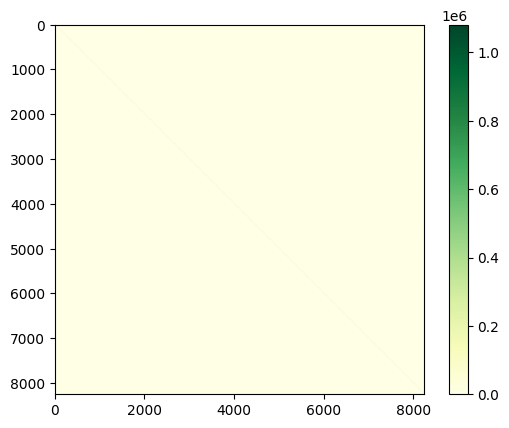

In [ ]:
# plt.figure()
# plt.imshow(L4, cmap='YlGn')
# plt.colorbar()
# plt.show()

In [1]:
# %%
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt
from os.path import join
from scipy.spatial.distance import cdist
from scipy.sparse import csgraph

# %% [markdown]
# # Run1

# %%
data_path = '/Users/zkavian/Desktop/Workspace/Python_code/GLMSingle/selected_voxels_session1_run1.nii.gz'
stat_img = nib.load(data_path)
selected_voxels = stat_img.get_fdata() #binary matrix (90,120,85)

results = np.load('/Users/zkavian/Downloads/GLMOutputs2-sub04-ses01/TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()
beta_values = betasmd = results['betasmd'][:,:,:,0:90]  #(90,120,85,90)

v1 = beta_values[selected_voxels.astype(bool), :] #(8252, 90)
mean_v1 = np.mean(v1, axis=-1)
L_task = 1./np.abs(mean_v1)


# %%
base_path = '/Volumes/McKeownLab/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
sub = '04'
ses = '2'
run = '1'

data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg_2mm.nii.gz'
data_path_org = join(base_path, f'sub-pd0{sub}',f'ses-{ses}','func', data_name)
data_run1 = nib.load(data_path_org).get_fdata() #(90, 128, 85, 850)

# %%
select_data = data_run1[selected_voxels.astype(bool), :]

num_trials = 90
trial_len = 9
active_voxel_data = np.zeros((select_data.shape[0], num_trials, trial_len))

start = 0
for i in range(num_trials):
    active_voxel_data[:, i, :] = select_data[:, start:start+trial_len]
    start += trial_len
    if start == 270 or start == 560:
        start += 20


# %%
diff_mat = np.diff(active_voxel_data, axis=1)
diff_mat_flat = diff_mat.reshape(diff_mat.shape[0], -1)
# C2 = diff_mat_flat @ diff_mat_flat.T
# L_var = C2 / active_voxel_data.shape[1]
L_var = np.cov(diff_mat_flat, bias=False)
# C2.shape

# %%
anat_img = nib.load('/Volumes/McKeownLab/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd004/ses-1/anat/sub-pd004_ses-1_T1w_brain_2mm.nii.gz')
anat_data = anat_img.get_fdata()

# %%
affine = anat_img.affine
shape = anat_img.shape

# Get all voxel indices
coords = np.array(np.meshgrid(
    np.arange(shape[0]),
    np.arange(shape[1]),
    np.arange(shape[2]),
    indexing='ij'
)).reshape(3, -1).T

# Convert to world (scanner/MNI) coordinates
world_coords = nib.affines.apply_affine(affine, coords)
tmp = selected_voxels.astype(bool).reshape(-1)
selected_world_coords = world_coords[tmp,:]

D = cdist(selected_world_coords, selected_world_coords)  

L_smooth = csgraph.laplacian(D)

In [2]:
print("Any NaN in selected_BOLD_data_reshape?", np.any(np.isnan(active_voxel_data)))
print("Any inf in selected_BOLD_data_reshape?", np.any(np.isinf(active_voxel_data)))
print("Any NaN in diff_mat?", np.any(np.isnan(diff_mat)))
print("Any NaN in L_var?", np.any(np.isnan(L_var)))

Any NaN in selected_BOLD_data_reshape? False
Any inf in selected_BOLD_data_reshape? False
Any NaN in diff_mat? False
Any NaN in L_var? False


In [3]:
import numpy as np
print(np.all(np.linalg.eigvals(np.diag(L_task)) >= -1e-10))  # Should be True
print(np.all(np.linalg.eigvals(L_var) >= -1e-10))   # Should be True
print(np.all(np.linalg.eigvals(L_smooth) >= -1e-10)) # Should be True

True
False
True


In [4]:
L_var = (L_var + L_var.T) / 2 + 1e-6 * np.eye(L_var.shape[0])
print(np.all(np.linalg.eigvals(L_var) >= -1e-10))

True


In [ ]:
# import numpy as np
# import cvxpy as cp


# def optimize_voxel_weights(
#     L_task: np.ndarray,
#     L_var: np.ndarray,
#     L_smooth: np.ndarray,
#     alpha_var: float = 1.0,
#     alpha_smooth: float = 0.1,
#     alpha_sparse: float = 0.01,
# ) -> np.ndarray:
    
#     L_total = np.diag(L_task) + alpha_var * L_var + alpha_smooth * L_smooth
#     w = cp.Variable(L_total.shape[0])
#     objective = cp.Minimize(cp.quad_form(w, L_total) + alpha_sparse * cp.norm1(w))
#     problem = cp.Problem(objective)
#     problem.solve()
#     return w.value


# weights = optimize_voxel_weights(
#     L_task, L_var, L_smooth, alpha_var=0.1, alpha_smooth=0.1, alpha_sparse=0.01
# )
# # print("Optimized weights shape:", weights.shape)
# y = select_data.T @ weights

# p95 = np.percentile(weights, 95)
# p5 = np.percentile(weights, 5)

In [6]:
import numpy as np
from itertools import product
from sklearn.model_selection import KFold
import cvxpy as cp

def objective_func(w, L_task, L_var, L_smooth,
              alpha_var, alpha_smooth, alpha_sparse):
    """Value of the full loss on a validation set."""
    quad = (w.T @ L_task @ w
            + alpha_var   * (w.T @ L_var    @ w)
            + alpha_smooth * (w.T @ L_smooth @ w))
    l1 = alpha_sparse * np.sum(np.abs(w))
    return quad + l1

def optimize_voxel_weights(
    L_task: np.ndarray,
    L_var: np.ndarray,
    L_smooth: np.ndarray,
    alpha_var: float = 1.0,
    alpha_smooth: float = 0.1,
    alpha_sparse: float = 0.01):
    
    L_total = np.diag(L_task) + alpha_var * L_var + alpha_smooth * L_smooth
    # L_total += 1e-6 * np.eye(L_total.shape[0])
    w = cp.Variable(L_total.shape[0])
    # print(4)
    objective = cp.Minimize(cp.quad_form(w, L_total) + alpha_sparse * cp.norm1(w))
    # print(5)
    # print(objective)
    problem = cp.Problem(objective)
    print(4)
    problem.solve(verbose=True)
    print(6)
    print(problem.status)
    print(7)
    return w.value


param_grid = {
    "alpha_var":   [0.1, 1.0, 10.0],
    "alpha_smooth":[0.0, 0.1, 1.0],
    "alpha_sparse":[0.001, 0.01, 0.1],
}

kf = KFold(n_splits=5, shuffle=True, random_state=0)
best_score = np.inf
best_params = None

for a_var, a_smooth, a_sparse in product(*param_grid.values()):
    print(f"a_var: {a_var}, a_smooth: {a_smooth}, a_sparse: {a_sparse}")
    fold_scores = []
    for train_idx, val_idx in kf.split(L_task):
        print(1)
        L_task_train = L_task[train_idx]
        L_var_train   = L_var[np.ix_(train_idx, train_idx)]
        L_smooth_train = L_smooth[np.ix_(train_idx, train_idx)]

        print(2)
        w = optimize_voxel_weights(
            L_task_train, L_var_train, L_smooth_train,
            alpha_var=a_var, alpha_smooth=a_smooth, alpha_sparse=a_sparse)
        
        print(5)
        # validation subsets
        L_task_val = L_task[val_idx]
        L_var_val   = L_var[np.ix_(val_idx, val_idx)]
        L_smooth_val = L_smooth[np.ix_(val_idx, val_idx)]

        print(3)
        fold_scores.append(
            objective_func(w, L_task_val, L_var_val, L_smooth_val,
                      a_var, a_smooth, a_sparse))

    print(mean_score)
    mean_score = np.mean(fold_scores)
    if mean_score < best_score:
        best_score = mean_score
        best_params = (a_var, a_smooth, a_sparse)

print("Best parameters:", best_params, "with CV loss:", best_score)


a_var: 0.1, a_smooth: 0.0, a_sparse: 0.001
1
2


(CVXPY) Aug 28 12:13:42 PM: Your problem has 6601 variables, 0 constraints, and 0 parameters.


4
                                     CVXPY                                     
                                     v1.7.2                                    


KeyboardInterrupt: 

In [ ]:
weights = optimize_voxel_weights(
    L_task, L_var, L_smooth, alpha_var=0.1, alpha_smooth=0.1, alpha_sparse=0.01
)
# print("Optimized weights shape:", weights.shape)
y = select_data.T @ weights

p95 = np.percentile(weights, 95)
p5 = np.percentile(weights, 5)

In [167]:
# print(weights.max())
# print(weights.min())
# weights.shape

In [168]:
# p95 = np.percentile(weights, 95)
# p5 = np.percentile(weights, 5)

# plt.hist(weights, bins=30, alpha=0.3, color='g')
# plt.axvline(p95, color='r', linestyle='dashed', linewidth=2)
# plt.axvline(p5, color='r', linestyle='dashed', linewidth=2)
# plt.show()

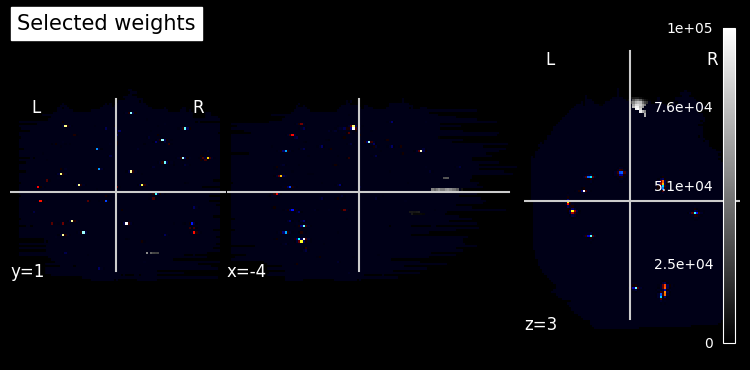

In [ ]:
selected_weights = np.where((weights <= p5) | (weights >= p95))[0]

from nilearn import plotting

weight_volume = np.zeros_like(selected_voxels, dtype=np.float32)
weight_volume[selected_voxels.astype(bool)] = weights  # put weights in their voxel positions

mask = np.zeros_like(weight_volume, dtype=bool)
selected_weights = (weights <= p5) | (weights >= p95)
mask[selected_voxels.astype(bool)] = selected_weights
weight_volume[~mask] = 0

masked_weights = np.where(weight_volume == 0, np.nan, weight_volume)
weight_img = nib.Nifti1Image(masked_weights, affine=anat_img.affine)

display = plotting.plot_anat(anat_img, dim=-0.5, title="Selected weights")
display.add_overlay(weight_img, cmap="cold_hot", threshold=1e-6)
plotting.show()

# weight_img = nib.Nifti1Image(weight_volume, affine=anat_img.affine)
# display = plotting.plot_anat(anat_img, dim=-0.5, title="Selected weights")
# display.add_overlay(weight_img, cmap="cold_hot", threshold=0)
# plotting.show()